In [ ]:
from recursos.utils import load_data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Configuración de rutas para utils
sys.path.append(os.path.abspath('../../'))

# Constantes del dataset
TARGET_COL = 'target_y'
COLS_TO_DROP = [TARGET_COL, 'malo_sf_inicio', 'periodo', 'Unnamed: 0']

# 1. Preparación del Caso
# Cargar datos usando utilidad centralizada
df = load_data('credit_scoring.csv')

# 🚨 INYECTAMOS LA FUGA (LEAKAGE) 🚨
# Creamos una variable que en la vida real NO tendríamos al momento de predecir.
# 'FuturePaymentStatus': 1 si pagó, 0 si no. Esto es básicamente el target disfrazado.
df['FuturePaymentStatus'] = np.where(
    df[TARGET_COL] == 0, 'Paid', 'Default')
# Añadimos un poco de ruido para que no sea obvio (99% correlación)
mask = np.random.rand(len(df)) < 0.01
df.loc[mask, 'FuturePaymentStatus'] = np.where(
    df.loc[mask, 'FuturePaymentStatus'] == 'Paid', 'Default', 'Paid')

# Codificamos la fuga como si fuera una variable normal
df['FuturePaymentStatus_Code'] = df['FuturePaymentStatus'].map(
    {'Paid': 0, 'Default': 1})
df = df.drop('FuturePaymentStatus', axis=1)

# Llenamos nulos rápido para que corra el modelo (no es el foco del ejercicio)
df = df.fillna(0)

print("Dataset preparado.")
print(f"Target: {TARGET_COL}")
print(f"Shape: {df.shape}")


Dataset preparado.
Target: target_y
Shape: (7180, 31)


### 📂 Diccionario de Datos (Credit Scoring)
Estamos trabajando con el mismo dataset de **Riesgo de Crédito**.
Recuerda las variables clave:
*   `target_y`: **Variable Objetivo**. 1 = Default, 0 = Good.
*   `FuturePaymentStatus_Code`: **Variable Sospechosa**. Apareció en el dataset misteriosamente. ¿Qué significa?
*   `MAX_PORC_DEUDA...`: Variables financieras legítimas.

# 🕵️‍♀️ Challenge: Detectives de Data Leakage

## 📑 Índice
1.  [Preparación del Caso](#1.-Preparación-del-Caso) 📁
2.  [El Crimen (Entrenamiento con Fuga)](#2.-El-Crimen-(Entrenamiento-con-Fuga)) 🚨
3.  [La Investigación (Tu Misión)](#3.-La-Investigación-(Tu-Misión)) 🔍
4.  [La Solución](#4.-La-Solución) ✅

---

## 💼 Caso de Negocio: El Modelo "Demasiado Bueno"
* **Contexto:** Un consultor externo entregó un modelo de riesgo crediticio con un **Accuracy del 99%**. La gerencia está feliz, pero tú, como Lead Data Scientist, sospechas.
* **El Problema:** En finanzas, "demasiado bueno para ser verdad" suele significar **Data Leakage**. Alguien usó información del futuro.
* **Tu Misión:** Auditar el modelo, encontrar la variable culpable (la fuga) y re-entrenar el modelo correctamente para ver su desempeño real.

## 🎯 Objetivos de Aprendizaje
1.  **Identificación:** Aprender a detectar fugas de información mediante análisis de Feature Importance.
2.  **Escepticismo:** Desarrollar el instinto crítico ante métricas perfectas.
3.  **Corrección:** Entender cómo eliminar variables que no estarían disponibles en el momento de la predicción.

## 2. El Crimen (Entrenamiento con Fuga)
Entrenamos un modelo Random Forest sin hacer muchas preguntas. Observa el resultado.

In [ ]:
# Preparar features eliminando columnas no deseadas
cols_to_drop_existing = [col for col in COLS_TO_DROP if col in df.columns]
X = df.drop(cols_to_drop_existing, axis=1)
y = df[TARGET_COL]

# Mantener solo columnas numéricas
X = X.select_dtypes(include=['int64', 'float64'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42, n_estimators=50, n_jobs=-1)
model.fit(X_train, y_train)

acc = accuracy_score(y_test, model.predict(X_test))
print(f"Accuracy: {acc:.4f}")
# Debería dar cerca de 1.0 debido a la variable con fuga


Accuracy: 0.9896


## 3. La Investigación (Tu Misión)
### 🧠 Micro-Desafío: Auditoría Forense
1.  Analiza la importancia de las variables (`feature_importances_`).
2.  Identifica cuál es la variable culpable que se lleva todo el crédito.
3.  Elimínala y re-entrena para ver el accuracy real.

> **💡 Pro-Tip:**
> En modelos de árboles (Random Forest, XGBoost), si una sola variable tiene una importancia desproporcionada (ej. > 0.8) comparada con las demás, es una **Red Flag** inmediata de Data Leakage.

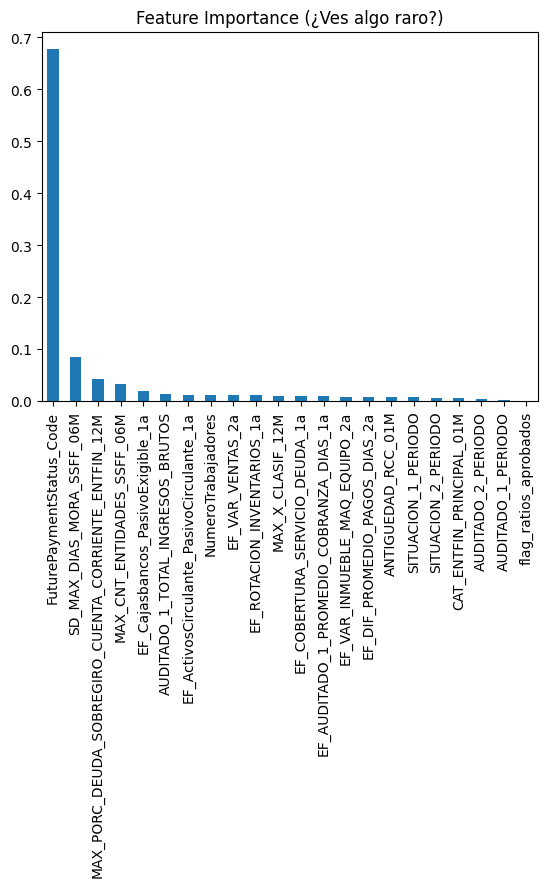

In [ ]:
# Pista:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar')
plt.title("Feature Importance (¿Ves algo raro?)")
plt.show()


## 4. La Solución
Elimina la variable `FuturePaymentStatus_Code` y vuelve a entrenar.

### ⚠️ Real-World Warning: ¿Cómo pasa esto en la vida real?
Nadie crea una columna llamada "FuturePaymentStatus" a propósito. Esto suele pasar por:
1.  **Errores de SQL:** Haces un JOIN con una tabla que contiene el estado actual del cliente (ej. tabla de cobranzas) en lugar de la foto histórica.
2.  **IDs Informativos:** A veces el ID del cliente cambia si entra en mora (ej. `C-123` pasa a ser `M-123`). Si el modelo ve la "M", ya sabe la respuesta.
3.  **Variables Temporales:** Usar "Días desde el último pago" calculado al día de hoy, en lugar de al día de la solicitud del crédito.

In [ ]:
# Escribe tu solución aquí
# X_clean = X.drop(...)
